In [ ]:
from __future__ import print_function

In [ ]:
%pylab inline
import pandas as pd
import seaborn as sns
from scipy import linalg

genes = pd.read_csv('gene_expression_s.csv', index_col=0).sort_index(0).sort_index(1)
sample_data = pd.read_csv('sample_info_qc.csv', index_col=0).sort_index(0).sort_index(1)

genes = genes.ix[:, sample_data[sample_data["Pass QC"]].index]
sample_data = sample_data[sample_data["Pass QC"]]

ercc_idx = filter(lambda i: 'ERCC' in i, genes.index)
egenes = genes.drop(ercc_idx)
egenes = egenes.drop('GFP')

egenes = (egenes / egenes.sum()) * 1e6

mask = (egenes > 1).sum(1) > 2
egenes = egenes.ix[mask]

gene_annotation = pd.read_csv('zv9_gene_annotation.txt', sep='\t', index_col=0)
gene_annotation = gene_annotation.ix[egenes.index]

In [ ]:
from sklearn.decomposition import FastICA, PCA
from sklearn.manifold import TSNE

In [ ]:
n = 4
ica = FastICA(n, random_state=3984)
Y = ica.fit_transform(np.log10(egenes.T + 1).copy())

XX = pd.DataFrame(Y, index=egenes.columns)
XX.columns = ['difference_component', 'within_small_component', 'outlier_component', 'within_large_component']
g = sns.PairGrid(XX)
# g.map(plt.scatter, c=np.log10(sample_data['488']))
g.map(plt.scatter, c='k')

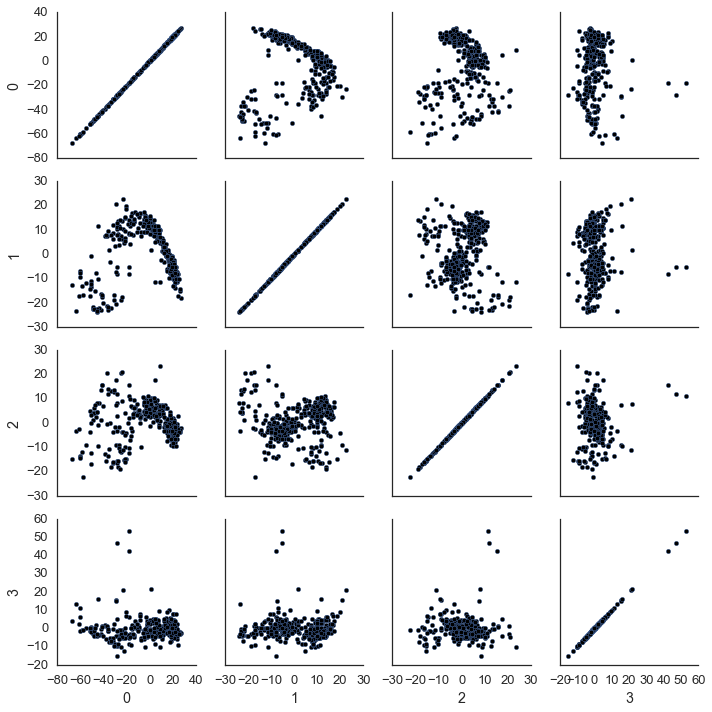

In [59]:
n = 4
pca = PCA(n)
Y_pca = pca.fit_transform(np.log10(egenes.T + 1).copy())

XX_pca = pd.DataFrame(Y_pca, index=egenes.columns)
# XX.columns = ['difference_component', 'within_small_component', 'outlier_component', 'within_large_component']
g = sns.PairGrid(XX_pca)
# g.map(plt.scatter, c=np.log10(sample_data['488']))
g.map(plt.scatter, c='k')

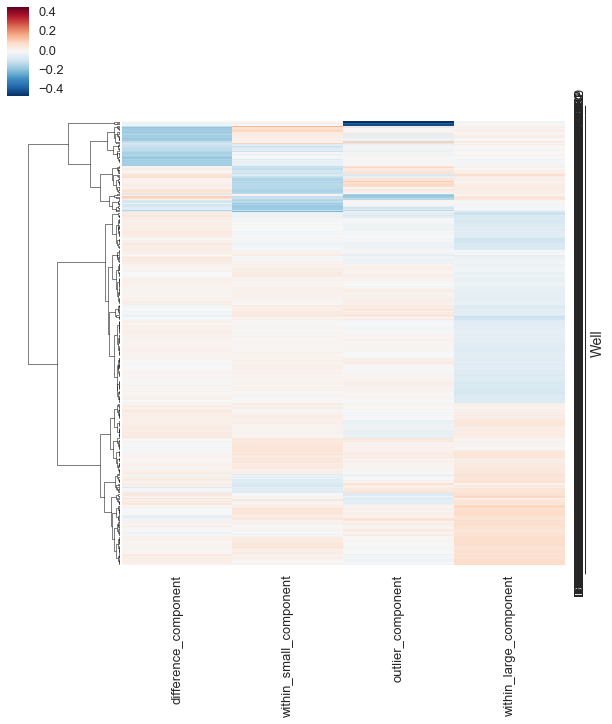

In [41]:
clm = sns.clustermap(XX, method='ward', lw=0, col_cluster=False);

In [42]:
XX.head()

,difference_component,within_small_component,outlier_component,within_large_component
Well,,,,
DIM_1_A1,0.078682,-0.104144,-0.119395,0.070390
DIM_1_A10,0.021386,0.020246,0.017293,0.073285
DIM_1_A11,-0.083068,-0.179175,-0.036702,-0.016871
DIM_1_A12,0.031794,-0.065027,0.034679,0.045065
DIM_1_A2,-0.015701,0.049654,0.072677,0.074522


In [43]:
# Put hidden components in sample data
for component in XX.columns:
    sample_data[component] = XX.ix[sample_data.index, component]

In [44]:
from scipy.cluster.hierarchy import dendrogram

In [45]:
from collections import defaultdict
from matplotlib.colors import rgb2hex, colorConverter 

class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html

def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = list(sorted([den[label][i] for i in l]))
        cluster_classes[c] = i_l

    return cluster_classes

def get_cluster_limits(den):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))

    cluster_limits = Clusters()
    for c in cluster_idxs:
        cluster_limits[c] = (min(cluster_idxs[c]), max(cluster_idxs[c]))
    
    return cluster_limits

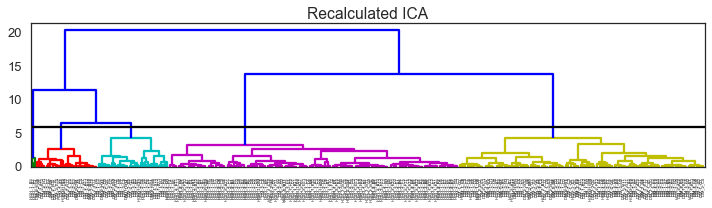

In [56]:
figsize(10, 3)
thr = 6
cden = dendrogram(clm.dendrogram_row.linkage, color_threshold=thr, labels=XX.index);
plt.axhline(thr, color='k');
plt.xticks(rotation=90, fontsize=4);
ax = plt.gca()
ax.set(title='Recalculated ICA');

In [47]:
true_clusters = {'1': ['DIM_1_A1', 'HIGH_1_G5', 'DIM_2_D6', 'DIM_1_C9', 'DIM_2_E12', 'DIM_2_D7', 'DIM_1_A11', 'DIM_2_B5', 'DIM_1_H1', 'DIM_1_F1', 'DIM_1_F10', 'DIM_2_A12', 'DIM_1_G11', 'HIGH_2_G1', 'DIM_1_D3', 'HIGH_2_C10', 'DIM_1_H4', 'DIM_1_H10', 'DIM_2_A6', 'DIM_2_F6', 'DIM_1_A12', 'DIM_1_B12', 'DIM_1_F3', 'DIM_2_D9', 'DIM_1_F6', 'DIM_1_G5', 'DIM_2_G7', 'DIM_1_D12', 'DIM_1_G4', 'DIM_2_C8', 'DIM_1_H6', 'DIM_1_H12', 'DIM_2_D5', 'DIM_1_F7', 'DIM_2_H11', 'DIM_2_A2', 'HIGH_1_C11', 'DIM_1_B7', 'DIM_1_A9', 'DIM_1_B9', 'DIM_2_G2', 'DIM_1_H9'],
                 '2': ['DIM_2_C11', 'HIGH_2_F12', 'DIM_1_C10', 'HIGH_2_G7', 'DIM_2_E10', 'DIM_2_G9', 'DIM_2_H10', 'DIM_2_H7', 'DIM_2_H8', 'DIM_2_C7', 'DIM_2_E7', 'DIM_2_B12', 'DIM_2_H1', 'DIM_1_G9', 'DIM_1_E7', 'DIM_2_A11', 'DIM_2_C10', 'DIM_1_H11', 'DIM_2_H5', 'DIM_1_B10', 'DIM_1_G12', 'DIM_2_B10', 'DIM_1_A5', 'DIM_2_C5', 'DIM_1_E12', 'DIM_1_E4', 'DIM_1_B5', 'DIM_2_F10', 'DIM_2_E1', 'DIM_2_E3', 'DIM_1_B4', 'DIM_2_G3', 'DIM_2_H12', 'DIM_1_D8'],
                 '3': ['DIM_1_H8', 'HIGH_1_A8', 'DIM_1_D7', 'DIM_1_E9', 'DIM_2_E5', 'DIM_2_G10', 'DIM_1_E11', 'DIM_1_H3', 'DIM_2_A7', 'DIM_1_C12', 'DIM_1_D9', 'DIM_1_C2', 'HIGH_1_B10', 'DIM_2_B11', 'DIM_1_C7', 'DIM_1_D2', 'DIM_2_D12', 'DIM_2_F9', 'HIGH_1_C6', 'DIM_2_B2', 'DIM_1_C1', 'DIM_1_G2', 'DIM_1_G8', 'DIM_2_D2', 'DIM_2_E9', 'DIM_2_B8', 'DIM_2_G12', 'DIM_2_A10', 'DIM_2_D8', 'HIGH_1_G6', 'HIGH_1_C8', 'DIM_2_F7', 'HIGH_2_C7', 'HIGH_2_E1', 'DIM_1_C6', 'DIM_2_C9', 'DIM_1_B8', 'DIM_2_D3', 'DIM_1_C6', 'DIM_2_E2', 'DIM_2_E4', 'DIM_2_C2', 'DIM_1_E6', 'DIM_1_F5', 'DIM_1_A7', 'DIM_2_F3', 'DIM_2_A3', 'DIM_2_B9', 'DIM_1_H2', 'DIM_1_E10', 'DIM_1_E8', 'DIM_2_C3', 'DIM_2_B3', 'HIGH_2_G9', 'DIM_2_B1', 'DIM_2_A8', 'DIM_2_F1', 'DIM_1_C11', 'DIM_1_F9', 'DIM_2_G6', 'DIM_1_G1', 'DIM_1_A6', 'DIM_1_F4', 'DIM_1_D11', 'DIM_2_F11', 'DIM_2_G11', 'DIM_1_D5', 'DIM_2_H9', 'DIM_1_B2', 'HIGH_2_H12', 'DIM_1_A2', 'DIM_2_F2', 'DIM_2_B7', 'DIM_1_A8', 'DIM_2_C12', 'DIM_2_D1', 'DIM_1_A10', 'DIM_1_F11', 'DIM_1_B1', 'DIM_1_G10', 'DIM_1_E3', 'DIM_2_A4', 'DIM_2_F5', 'DIM_1_D6', 'DIM_2_G4', 'DIM_1_F2', 'DIM_1_E2', 'DIM_2_E8', 'DIM_2_G5', 'DIM_1_C3', 'DIM_1_G6', 'HIGH_1_E3', 'DIM_2_D11', 'DIM_2_F4', 'DIM_2_A1', 'HIGH_2_G6', 'DIM_1_B6', 'DIM_1_F8', 'DIM_1_C5', 'DIM_2_H6', 'DIM_1_G3', 'DIM_2_C4', 'DIM_1_A3', 'HIGH_2_B7', 'DIM_1_G3', 'DIM_2_F8', 'DIM_2_G8', 'HIGH_2_F3', 'DIM_1_E1', 'DIM_2_F12', 'DIM_2_B6', 'HIGH_2_H6', 'DIM_1_H5', 'HIGH_2_A7', 'HIGH_1_H8', 'DIM_2_C1', 'HIGH_1_B2', 'DIM_2_H3', 'DIM_1_G7', 'DIM_2_B4', 'DIM_2_E6', 'DIM_1_B3', 'DIM_1_B11', 'DIM_2_H2', 'DIM_1_H7', 'DIM_2_G1', 'DIM_2_E11', 'DIM_1_C4', 'DIM_2_H4', 'DIM_1_D1', 'DIM_1_E5'],
                 '4': ['HIGH_1_H3', 'HIGH_2_F4', 'HIGH_1_A6', 'HIGH_2_E11', 'HIGH_1_H1', 'HIGH_2_A6', 'HIGH_2_F6', 'HIGH_2_A3', 'HIGH_2_F10', 'HIGH_2_F9', 'HIGH_2_G4', 'HIGH_1_G4', 'HIGH_1_H4', 'HIGH_2_G4', 'HIGH_1_F1', 'HIGH_2_G3', 'HIGH_2_C9', 'HIGH_2_H8', 'HIGH_2_C8', 'HIGH_2_H5', 'HIGH_1_F4', 'HIGH_2_E12', 'HIGH_1_A7', 'HIGH_2_B6', 'HIGH_1_B7', 'HIGH_1_A4', 'HIGH_1_E10', 'HIGH_1_H2', 'HIGH_1_A10', 'HIGH_1_H7', 'HIGH_1_D2', 'HIGH_2_E10', 'HIGH_1_A9', 'HIGH_1_C3', 'HIGH_2_A12', 'HIGH_2_H2', 'HIGH_1_B1', 'HIGH_1_F10', 'HIGH_1_D8', 'HIGH_1_E4', 'HIGH_1_H5', 'HIGH_2_E3', 'HIGH_1_E6', 'HIGH_1_A3', 'HIGH_1_B4', 'HIGH_2_D8', 'HIGH_2_B12', 'HIGH_2_E8', 'HIGH_1_E12', 'HIGH_2_E2', 'HIGH_1_E11', 'HIGH_2_E9', 'HIGH_1_E1', 'HIGH_1_B12', 'HIGH_2_C3', 'HIGH_2_H1', 'HIGH_1_E5', 'HIGH_2_A8', 'HIGH_2_F8', 'HIGH_1_D3', 'HIGH_2_F1', 'HIGH_1_H9', 'HIGH_2_F5', 'HIGH_2_B9', 'HIGH_1_C9', 'HIGH_2_F7', 'HIGH_2_F11', 'HIGH_1_A1', 'HIGH_2_D7', 'HIGH_2_D6', 'HIGH_2_D12', 'HIGH_2_H11', 'HIGH_1_G2', 'HIGH_1_D12', 'HIGH_2_B8', 'DIM_2_C6', 'HIGH_1_H6', 'HIGH_1_C5', 'HIGH_1_D9', 'HIGH_1_G3', 'HIGH_1_D6', 'HIGH_1_G8', 'HIGH_1_B6', 'HIGH_2_D2', 'HIGH_1_F9', 'HIGH_2_B11', 'HIGH_1_H11', 'HIGH_2_E4', 'HIGH_2_G11', 'HIGH_1_B11', 'HIGH_1_D1', 'HIGH_1_H10', 'HIGH_1_A5', 'HIGH_1_C4', 'HIGH_1_F3', 'HIGH_1_A11', 'HIGH_1_D5', 'HIGH_2_D11', 'HIGH_1_G12', 'HIGH_2_A2', 'HIGH_1_B5', 'HIGH_1_C10', 'HIGH_1_D11', 'HIGH_2_C4', 'HIGH_1_B5', 'HIGH_1_F11', 'HIGH_2_H3', 'HIGH_1_D7', 'HIGH_2_A11', 'HIGH_2_D1', 'HIGH_1_F5', 'HIGH_2_G8', 'HIGH_2_D3', 'HIGH_2_A4', 'HIGH_2_D9', 'HIGH_1_E9', 'HIGH_2_A10', 'HIGH_2_A5', 'HIGH_1_E8', 'HIGH_2_B1', 'HIGH_2_A9', 'HIGH_2_C12', 'HIGH_2_D5', 'HIGH_2_E7', 'HIGH_1_F6', 'HIGH_2_B2', 'HIGH_2_B5', 'HIGH_2_C11', 'HIGH_2_G2', 'HIGH_2_F2', 'HIGH_1_E8', 'HIGH_1_F12', 'HIGH_2_H7', 'HIGH_1_E7', 'HIGH_2_H10', 'HIGH_1_C2', 'HIGH_2_G12', 'HIGH_2_B4', 'HIGH_2_H4', 'HIGH_2_G5', 'HIGH_2_B3', 'HIGH_1_G10', 'HIGH_2_C6', 'DIM_2_A5', 'HIGH_1_G11', 'HIGH_1_G9', 'HIGH_1_B8', 'HIGH_1_C1', 'HIGH_1_H12', 'HIGH_2_C2', 'HIGH_1_B3', 'HIGH_2_B10', 'HIGH_2_H9', 'HIGH_1_G7', 'HIGH_2_C1', 'HIGH_1_G1', 'HIGH_2_C5', 'HIGH_2_G10'],
                 'x': ['HIGH_1_A2', 'HIGH_1_F2', 'HIGH_1_B9']}
    

In [48]:
clusters = get_cluster_classes(cden)
clusters

y,"['DIM_1_A10', 'DIM_1_A12', 'DIM_1_A2', 'DIM_1_A3', 'DIM_1_A6', 'DIM_1_A7', 'DIM_1_B1', 'DIM_1_B11', 'DIM_1_B12', 'DIM_1_B2', 'DIM_1_B3', 'DIM_1_B5', 'DIM_1_B6', 'DIM_1_B8', 'DIM_1_C1', 'DIM_1_C11', 'DIM_1_C12', 'DIM_1_C2', 'DIM_1_C3', 'DIM_1_C4', 'DIM_1_C5', 'DIM_1_C6', 'DIM_1_C7', 'DIM_1_D1', 'DIM_1_D11', 'DIM_1_D2', 'DIM_1_D3', 'DIM_1_D5', 'DIM_1_D6', 'DIM_1_D6', 'DIM_1_D7', 'DIM_1_D9', 'DIM_1_E1', 'DIM_1_E10', 'DIM_1_E11', 'DIM_1_E11', 'DIM_1_E2', 'DIM_1_E3', 'DIM_1_E3', 'DIM_1_E5', 'DIM_1_E6', 'DIM_1_E8', 'DIM_1_E9', 'DIM_1_F11', 'DIM_1_F2', 'DIM_1_F4', 'DIM_1_F5', 'DIM_1_F8', 'DIM_1_F9', 'DIM_1_G1', 'DIM_1_G10', 'DIM_1_G2', 'DIM_1_G3', 'DIM_1_G6', 'DIM_1_G7', 'DIM_1_G8', 'DIM_1_H10', 'DIM_1_H2', 'DIM_1_H3', 'DIM_1_H4', 'DIM_1_H5', 'DIM_1_H5', 'DIM_1_H7', 'DIM_1_H8', 'DIM_2_A10', 'DIM_2_A3', 'DIM_2_A4', 'DIM_2_A7', 'DIM_2_A8', 'DIM_2_B1', 'DIM_2_B11', 'DIM_2_B2', 'DIM_2_B3', 'DIM_2_B4', 'DIM_2_B6', 'DIM_2_B7', 'DIM_2_B8', 'DIM_2_B9', 'DIM_2_C1', 'DIM_2_C12', 'DIM_2_C12', 'DIM_2_C2', 'DIM_2_C3', 'DIM_2_C4', 'DIM_2_C9', 'DIM_2_D1', 'DIM_2_D11', 'DIM_2_D12', 'DIM_2_D2', 'DIM_2_D3', 'DIM_2_D8', 'DIM_2_E11', 'DIM_2_E2', 'DIM_2_E4', 'DIM_2_E5', 'DIM_2_E5', 'DIM_2_E6', 'DIM_2_E8', 'DIM_2_E9', 'DIM_2_F1', 'DIM_2_F11', 'DIM_2_F12', 'DIM_2_F2', 'DIM_2_F3', 'DIM_2_F4', 'DIM_2_F5', 'DIM_2_F7', 'DIM_2_F8', 'DIM_2_F9', 'DIM_2_G1', 'DIM_2_G10', 'DIM_2_G11', 'DIM_2_G12', 'DIM_2_G4', 'DIM_2_G5', 'DIM_2_G6', 'DIM_2_G7', 'DIM_2_G8', 'DIM_2_H2', 'DIM_2_H3', 'DIM_2_H4', 'DIM_2_H6', 'DIM_2_H9', 'HIGH_1_A8', 'HIGH_1_B10', 'HIGH_1_B2', 'HIGH_1_C6', 'HIGH_1_C8', 'HIGH_1_E3', 'HIGH_1_G6', 'HIGH_1_H8', 'HIGH_2_A12', 'HIGH_2_A7', 'HIGH_2_B7', 'HIGH_2_C10', 'HIGH_2_F3', 'HIGH_2_G9', 'HIGH_2_H12', 'HIGH_2_H6']"
c,"['DIM_1_A1', 'DIM_1_A11', 'DIM_1_A9', 'DIM_1_A9', 'DIM_1_B7', 'DIM_1_B9', 'DIM_1_C9', 'DIM_1_D12', 'DIM_1_D8', 'DIM_1_F1', 'DIM_1_F10', 'DIM_1_F3', 'DIM_1_F6', 'DIM_1_F7', 'DIM_1_G11', 'DIM_1_G4', 'DIM_1_G5', 'DIM_1_H1', 'DIM_1_H12', 'DIM_1_H6', 'DIM_1_H9', 'DIM_2_A1', 'DIM_2_A12', 'DIM_2_A2', 'DIM_2_A6', 'DIM_2_B5', 'DIM_2_C8', 'DIM_2_D5', 'DIM_2_D6', 'DIM_2_D7', 'DIM_2_D9', 'DIM_2_E12', 'DIM_2_F6', 'DIM_2_G2', 'DIM_2_H11', 'HIGH_1_C11', 'HIGH_1_G5', 'HIGH_2_G1', 'HIGH_2_G6']"
r,"['DIM_1_A5', 'DIM_1_A8', 'DIM_1_B10', 'DIM_1_B4', 'DIM_1_C10', 'DIM_1_E12', 'DIM_1_E4', 'DIM_1_E7', 'DIM_1_G12', 'DIM_1_G9', 'DIM_1_H11', 'DIM_2_A11', 'DIM_2_B10', 'DIM_2_B12', 'DIM_2_C10', 'DIM_2_C11', 'DIM_2_C5', 'DIM_2_C7', 'DIM_2_E1', 'DIM_2_E10', 'DIM_2_E3', 'DIM_2_E7', 'DIM_2_F10', 'DIM_2_G3', 'DIM_2_G9', 'DIM_2_H1', 'DIM_2_H10', 'DIM_2_H12', 'DIM_2_H5', 'DIM_2_H7', 'DIM_2_H8', 'HIGH_2_F12', 'HIGH_2_G7']"
m,"['DIM_2_A5', 'DIM_2_C6', 'HIGH_1_A1', 'HIGH_1_A10', 'HIGH_1_A11', 'HIGH_1_A3', 'HIGH_1_A4', 'HIGH_1_A5', 'HIGH_1_A6', 'HIGH_1_A7', 'HIGH_1_A9', 'HIGH_1_B1', 'HIGH_1_B11', 'HIGH_1_B12', 'HIGH_1_B3', 'HIGH_1_B4', 'HIGH_1_B5', 'HIGH_1_B6', 'HIGH_1_B7', 'HIGH_1_B8', 'HIGH_1_C1', 'HIGH_1_C10', 'HIGH_1_C2', 'HIGH_1_C3', 'HIGH_1_C4', 'HIGH_1_C5', 'HIGH_1_C9', 'HIGH_1_D1', 'HIGH_1_D11', 'HIGH_1_D12', 'HIGH_1_D2', 'HIGH_1_D3', 'HIGH_1_D5', 'HIGH_1_D6', 'HIGH_1_D7', 'HIGH_1_D8', 'HIGH_1_D9', 'HIGH_1_E1', 'HIGH_1_E10', 'HIGH_1_E11', 'HIGH_1_E12', 'HIGH_1_E4', 'HIGH_1_E5', 'HIGH_1_E6', 'HIGH_1_E7', 'HIGH_1_E8', 'HIGH_1_E8', 'HIGH_1_E9', 'HIGH_1_F1', 'HIGH_1_F10', 'HIGH_1_F11', 'HIGH_1_F12', 'HIGH_1_F3', 'HIGH_1_F4', 'HIGH_1_F5', 'HIGH_1_F6', 'HIGH_1_F9', 'HIGH_1_G1', 'HIGH_1_G10', 'HIGH_1_G11', 'HIGH_1_G12', 'HIGH_1_G2', 'HIGH_1_G3', 'HIGH_1_G4', 'HIGH_1_G7', 'HIGH_1_G8', 'HIGH_1_G9', 'HIGH_1_H1', 'HIGH_1_H10', 'HIGH_1_H11', 'HIGH_1_H12', 'HIGH_1_H2', 'HIGH_1_H3', 'HIGH_1_H4', 'HIGH_1_H5', 'HIGH_1_H6', 'HIGH_1_H7', 'HIGH_1_H9', 'HIGH_2_A10', 'HIGH_2_A11', 'HIGH_2_A2', 'HIGH_2_A3', 'HIGH_2_A4', 'HIGH_2_A5', 'HIGH_2_A6', 'HIGH_2_A8', 'HIGH_2_A9', 'HIGH_2_B1', 'HIGH_2_B10', 'HIGH_2_B11', 'HIGH_2_B12', 'HIGH_2_B2', 'HIGH_2_B3', 'HIGH_2_B4', 'HIGH_2_B5', 'HIGH_2_B6', 'HIGH_2_B8', 'HIGH_2_B9', 'HIGH_2_C1', 'HIGH_2_C11', 'HIGH_2_C12', 'HIGH_2_C2', 'HIGH_2_C3', 'HIGH_2_C4'

In [49]:
lines = []

for name, true_cells in true_clusters.items():
    true_cells = set(true_cells)
    for color, test_cells in clusters.items():
        overlap = true_cells & set(test_cells)
        lines.append([name, color, len(overlap), overlap])
cluster_overlap = pd.DataFrame(lines, columns=['Cluster Name', 'Cluster Color', 'Size of overlap', 'Overlapping cells'])
cluster_overlap.head()

,Cluster Name,Cluster Color,Size of overlap,Overlapping cells
0,1,y,7,"{HIGH_2_C10, DIM_1_H4, DIM_1_A12, DIM_2_G7, DI..."
1,1,c,35,"{DIM_1_G4, DIM_1_C9, DIM_1_A9, DIM_1_A1, DIM_2..."
2,1,r,0,{}
3,1,m,0,{}
4,1,g,0,{}


In [50]:
cluster_overlap_2d = cluster_overlap.pivot(index='Cluster Name', columns='Cluster Color', values='Size of overlap')
cluster_overlap_2d

Cluster Color,c,g,m,r,y
Cluster Name,,,,,
1,35,0,0,0,7
2,1,0,0,32,1
3,2,0,2,1,124
4,0,0,154,0,1
x,0,3,0,0,0


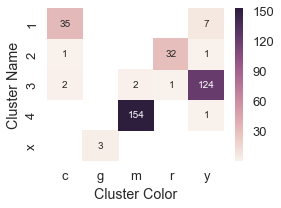

In [51]:
sns.set(style='white', context='talk')
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(cluster_overlap_2d[cluster_overlap_2d > 0], annot=True, fmt='.0f')

Read supplementary data:

In [52]:
original_experiment_sample_info = pd.read_csv('../supplementary-data-1-sample-info/original_experiment_sample_info.csv', index_col=0)
original_experiment_sample_info.head()

,% Parent,% Total,3'UTR_Exons,488,5'UTR_Exons,561,Average mapped length,CDS_Exons,Cells,ERCC Content,...,molecule_r2,outlier_component,total_molecules,within_large_component,within_small_component,cluster_color,tsne_0,tsne_1,log_488,log_SSC
Well,,,,,,,,,,,,,,,,,,,,,
DIM_1_A1,NaN,100.00%,615178,80,118167,6,229.53,1273306,1,116339.14620,...,0.849279,-0.119395,2884413,0.070390,-0.104144,"(0.55432528607985565, 0.62711267120697922, 0.7...",-0.357368,12.650468,1.903090,1.995635
DIM_1_A10,NaN,100.00%,625664,39,99645,1,230.31,1032911,1,279412.04190,...,0.853730,0.017293,794642,0.073285,0.020246,"(0.90311419262605563, 0.54185316071790801, 0.7...",-0.001426,6.763604,1.591065,1.579784
DIM_1_A11,NaN,100.00%,733798,53,245374,1,230.64,3031565,1,24324.44224,...,0.778746,-0.036702,9513110,-0.016871,-0.179175,"(0.55432528607985565, 0.62711267120697922, 0.7...",-8.698019,8.706809,1.724276,2.206826
DIM_1_A12,NaN,100.00%,827658,337,148061,9,230.22,1597099,1,186802.23200,...,0.901161,0.034679,1243023,0.045065,-0.065027,"(0.55432528607985565, 0.62711267120697922, 0.7...",-4.495216,11.184408,2.527630,2.068186
DIM_1_A2,NaN,100.00%,187244,83,38552,5,229.60,322876,1,251667.90200,...,0.817718,0.072677,902531,0.074522,0.049654,"(0.90311419262605563, 0.54185316071790801, 0.7...",-1.362267,3.037966,1.919078,1.892095


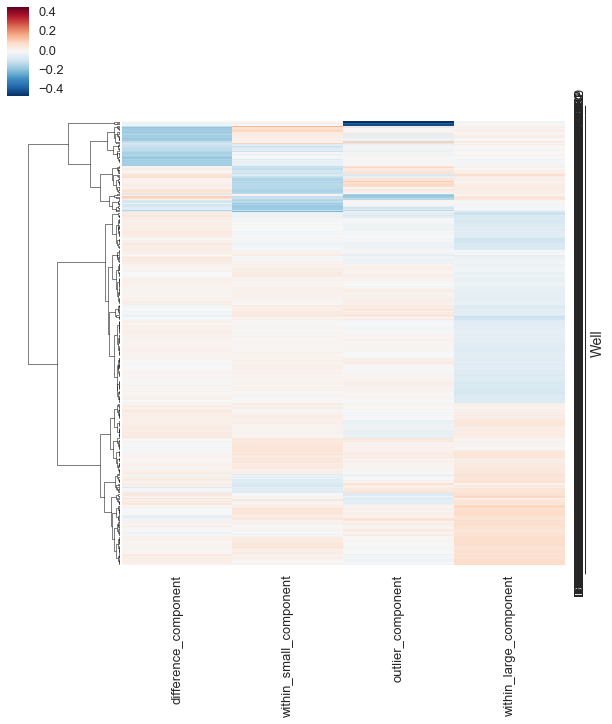

In [39]:
original_ica_XX = original_experiment_sample_info[XX.columns]
original_clm = sns.clustermap(original_ica_XX, method='ward', lw=0, col_cluster=False);

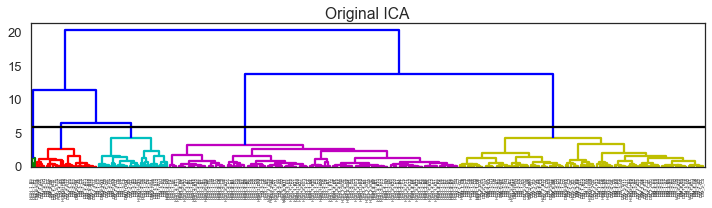

In [57]:
figsize(10, 3)
thr = 6
original_cden = dendrogram(original_clm.dendrogram_row.linkage, color_threshold=thr, labels=XX.index);
plt.axhline(thr, color='k');
plt.xticks(rotation=90, fontsize=4);
ax = plt.gca()
ax.set(title='Original ICA');

In [ ]:
# figsize(10, 3)
# thr = 0.442
# finer_den = dendrogram(clm.dendrogram_row.linkage, color_threshold=thr, labels=XX.index);
# plt.axhline(thr, color='k');
# plt.xticks(rotation=90, fontsize=4);

In [ ]:
finer_clusters = get_cluster_classes(finer_den)
finer_clusters

In [ ]:
cell_color = []
for cell in XX.index:
    for color in clusters:
        if cell in clusters[color]:
            cell_color.append(color)
            break

In [ ]:
XX = pd.DataFrame(Y, index=egenes.columns)
g = sns.PairGrid(XX)
g.map(plt.scatter, color=cell_color)

In [ ]:
figsize(6, 6)

sm_ica = TSNE(n_components=2, perplexity=75, random_state=254)

XX2 = sm_ica.fit_transform(XX.copy())
XX2 = pd.DataFrame(XX2, index=XX.index)
plt.scatter(XX2[0], XX2[1], c=cell_color);

In [ ]:
finer_cell_color = []
for cell in XX.index:
    for color in finer_clusters:
        if cell in finer_clusters[color]:
            finer_cell_color.append(color)
            break

In [ ]:
figsize(6, 6)

sm_ica = TSNE(n_components=2, perplexity=75, random_state=254)

XX2 = sm_ica.fit_transform(XX.copy())
XX2 = pd.DataFrame(XX2, index=XX.index)
plt.scatter(XX2[0], XX2[1], c=finer_cell_color);

In [ ]:
named_clusters = {}

In [ ]:
named_clusters['1a'] = finer_clusters['c']
named_clusters['1b'] = finer_clusters['m']
named_clusters['2'] = clusters['y']
named_clusters['3'] = clusters['m']
named_clusters['4'] = clusters['g']
named_clusters['x'] = clusters['r']

In [ ]:
cl_plt = sns.color_palette("Set2", 5)
named_cluster_colors = {'1a' : cl_plt[0],
                        '1b' : cl_plt[1],
                        '2' : cl_plt[2],
                        '3' : cl_plt[3],
                        '4' : cl_plt[4],
                        'x' : (0.8, 0.8, 0.8)}

In [ ]:
cell_cluster = []
for cell in sample_data.index:
    for cluster in named_clusters:
        if cell in named_clusters[cluster]:
            cell_cluster.append(cluster)
            break

In [ ]:
sample_data['cluster'] = cell_cluster

In [ ]:
sample_data.groupby('cluster').size()

In [ ]:
sample_data['cluster_color'] = sample_data['cluster'].map(named_cluster_colors)

In [ ]:
sample_data['tsne_0'] = XX2[0][sample_data.index]
sample_data['tsne_1'] = XX2[1][sample_data.index]

In [ ]:
s_d_mean = sample_data.query('cluster != "x"').groupby('cluster').mean()

In [ ]:
s_d_first = sample_data.query('cluster != "x"').groupby('cluster').first()

In [ ]:
sample_data.condition.value_counts()

In [ ]:
sample_data['condition_color'] = ['#31a354' if c == 'HIGH' else '#e5f5e0' for c in sample_data['condition']]

In [ ]:
sns.set_style('white')
sns.set_context('talk')

plt.scatter(sample_data['tsne_0'], sample_data['tsne_1'],
            color=sample_data['condition_color'],
            s=100, edgecolor='k');

plt.axis('off');
plt.tight_layout();
plt.savefig('figures/tsne_dim_bright.pdf')

In [ ]:
sns.set_style('white')
sns.set_context('talk')

plt.scatter(sample_data['tsne_0'], sample_data['tsne_1'],
            color=sample_data['cluster_color'],
            s=100, edgecolor='k');

# plt.plot(s_d_mean['tsne_0'], s_d_mean['tsne_1'],
#          alpha=0.075,
#          color='k',
#          zorder=0,
#          lw=20,
#          )

plt.text(s_d_mean['tsne_0']['1a'] - 3,
         s_d_mean['tsne_1']['1a'] - 2.5,
         '1a',
         color=s_d_first.cluster_color['1a'],
         size=16
         )

plt.text(s_d_mean['tsne_0']['1b'] - 3,
         s_d_mean['tsne_1']['1b'] - 0,
         '1b',
         color=s_d_first.cluster_color['1b'],
         size=16
         )

plt.text(s_d_mean['tsne_0']['2'] - 0.5,
         s_d_mean['tsne_1']['2'] + 3.5,
         '2',
         color=s_d_first.cluster_color['2'],
         size=16
         )

plt.text(s_d_mean['tsne_0']['3'] + 5.3,
         s_d_mean['tsne_1']['3'] + 2.5,
         '3',
         color=s_d_first.cluster_color['3'],
         size=16
         )

plt.text(s_d_mean['tsne_0']['4'] + 7,
         s_d_mean['tsne_1']['4'],
         '4',
         color=s_d_first.cluster_color['4'],
         size=16
         )

plt.axis('off');
plt.tight_layout();
plt.savefig('figures/tsne_clusters.pdf')

In [ ]:
comp_cols = filter(lambda n: '_component' in n, sample_data.columns)

In [ ]:
g = sns.PairGrid(sample_data[comp_cols])
g.map(plt.scatter, color=sample_data['condition_color'], edgecolor='k')
for ax in g.axes.flatten():
    ax.set_xticks([]);
    ax.set_yticks([]);
    
plt.tight_layout()
plt.savefig('figures/ica_condition.pdf');

In [ ]:
g = sns.PairGrid(sample_data[comp_cols])
g.map(plt.scatter, color=sample_data['cluster_color'], edgecolor='k')
for ax in g.axes.flatten():
    ax.set_xticks([]);
    ax.set_yticks([]);
    
plt.tight_layout()
plt.savefig('figures/ica_clusters.pdf');

In [ ]:
sample_data.groupby('cluster').mean()['within_small_component']

In [ ]:
sample_data.groupby('cluster').mean()['488']

In [ ]:
for clid in sorted(sample_data['cluster'].unique()):
    gfp_flourenscence = sample_data.query('cluster == "{}"'.format(clid))['488']
    sns.distplot(np.log10(gfp_flourenscence),
                 color=sample_data['cluster_color'][gfp_flourenscence.index[0]],
                 hist=False,
                 label=clid)

plt.legend();

>Variation in cell size properties as projected through FSC is expected to be small, for example, the smallest cell are approximately 6-7 micron while the largest can reach no more than 10 times that size, This can be easily represented in a linear scale.
The same goes for SSC which changes mainly as result of the granules size and numbers.
Fluorescence however can change in many folds and thus is necessary to present in log scale. 
Having said that, switching between logs and linear scales, is possible and the log linear scales you describe are only the default software choice. 

In [ ]:
figsize(12, 4)

plt.subplot(1, 2, 1)
for clid in sorted(sample_data['cluster'].unique()):
    gfp_flourenscence = sample_data.query('cluster == "{}"'.format(clid))['FSC Horizontal']
    sns.distplot(gfp_flourenscence,
                 color=sample_data['cluster_color'][gfp_flourenscence.index[0]],
                 kde_kws={'shade': True},
                 hist=False,
                 label=clid)

plt.xlabel('FSC Horizontal (cell size)')
plt.ylabel('Density')
    
plt.subplot(1, 2, 2)
for clid in sorted(sample_data['cluster'].unique()):
    gfp_flourenscence = sample_data.query('cluster == "{}"'.format(clid))['SSC']
    sns.distplot(gfp_flourenscence,
                 color=sample_data['cluster_color'][gfp_flourenscence.index[0]],
                 kde_kws={'shade': True},
                 hist=False,
                 label=clid)
    
plt.xlabel('SSC (cell granularity)')

sns.despine()
plt.legend();

plt.tight_layout();
plt.savefig('figures/clusters_FSC_SSC.pdf')

In [ ]:
sample_data['log_488'] = np.log10(sample_data['488'])
sample_data['log_SSC'] = np.log10(sample_data['SSC'])
g = sns.PairGrid(sample_data[['log_488', 'FSC Horizontal', 'log_SSC']])
g.map(plt.scatter, color=sample_data['cluster_color'], edgecolor='k')

In [ ]:
sample_data.to_csv('sample_info_qc.csv')

### Expression of thrombocyte markers in outliers

In [ ]:
# fli1a
egenes.ix['ENSDARG00000054632', sample_data.query('cluster == "x"').index]

In [ ]:
# gata1a
egenes.ix['ENSDARG00000013477', sample_data.query('cluster == "x"').index]

In [ ]:
# gf1b
egenes.ix['ENSDARG00000079947', sample_data.query('cluster == "x"').index]

In [ ]:
# gp1bb
egenes.ix['ENSDARG00000074441', sample_data.query('cluster == "x"').index]

In [ ]:
# itga3b
egenes.ix['ENSDARG00000012824', sample_data.query('cluster == "x"').index]